# Морфология 2
В данном ноутбуке находится задание на триграммы и словарь. В качестве текста будем использовать томик войны и мира: https://goo.gl/qcVTLE 

Для начала напомним некоторые полезные инструменты на питоне

## 1. Инструменты

### 1.1. Регулярные выражения
Исчерпывающий пост https://habr.com/ru/post/349860/

In [3]:
import re

# С помощью рег. выражения можно искать, заменять и сентезировать строки по шаблонам
# Парочка простых примеров
numbers = re.findall(r'\d+', r'There is some numbers: 49 and 432')
print('Находим числа в строке: ', numbers)

print('Простенький токенизатор: ', re.sub('[,\.?!]',' ','How, to? split. text!').split())

print('Еще один токенизатор: ', re.split(r'\W+', 'How, to? split. text! Again'))

# в качестве тренировки придумайте свой токенизатор в случае, когда из текста нужно получить только русские слова.

Находим числа в строке:  ['49', '432']
Простенький токенизатор:  ['How', 'to', 'split', 'text']
Еще один токенизатор:  ['How', 'to', 'split', 'text', 'Again']


### 1.2. Чтение файлов
Чтобы не мучится самим с кодировками, приведем способ чтения файла корпуса.

In [59]:
import io
wordlilist = None
text_file_path = 'wp.txt'
with io.open(text_file_path, "r") as text_file:
    text = text_file.read()
    # wordlist = Здесь заиспользуем токенизатор. Также приведем все слова к нижнему регистру.

### 1.3. ООП
В питоне можно создавать свои классы, скорее всего нам понадобится класс для хранения бора

In [62]:
class Node:
    def __init__(self):
        '''
        Simple constructor without params
        '''
        pass
    
    def method(self, par):
        '''
        Simple method with one param
        '''
        pass
    
# все данные хранятся в self, поэтому он и передается первым аргументом во все методы

### 1.4. pyplot
Довольно часто приходится построить какие-нибудт графики и гистограммы для изучения данных, с которыми придется работать. Для этого в питоне есть удобнейший модуль для этого - pyplot. Туториал: https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html

In [63]:
#!pip install matplotlib # Установка модуля
import matplotlib.pyplot as plt
# команда чтобы картинки рисовались прямо в ноутбуке
%matplotlib inline 

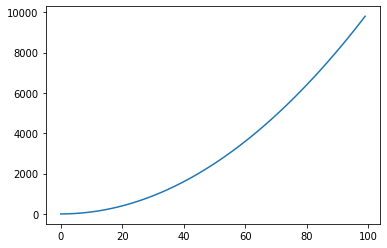

In [64]:
# Посмотрим на график функции x^2
data = [i * i for i in range(100)]
plt.plot(data)

(array([32., 13., 10.,  8.,  8.,  6.,  6.,  6.,  5.,  6.]),
 array([   0. ,  980.1, 1960.2, 2940.3, 3920.4, 4900.5, 5880.6, 6860.7,
        7840.8, 8820.9, 9801. ]),
 <BarContainer object of 10 artists>)

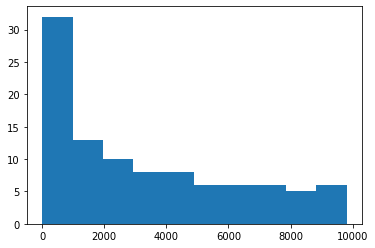

In [65]:
# и распределение по значениям
plt.hist(data)

Также полезная команда для подсчета времения выполнеия в ячейке

In [66]:
%%time
res = 0
for i in range(int(1e8)):
    res += 1

CPU times: user 6.56 s, sys: 734 µs, total: 6.56 s
Wall time: 6.56 s


## 2. Задание
Собственно теперь нам потребуется написать подсчет триграмм и бор для словаря, чтобы реализовать простенькую систему исправления ошибок.

### 2.1. Триграммы
Для начала получим словарь триграмма - её кол-во в тексте, не забывая о начале и конце слова.

Далее можно построить гистограмму на кол-во вхождений триграмм, и посмотреть самые частые и какая частота у каких-нибудь заведомо странных, например: 'чгк', 'шкя' и подобные. Из полученных данных придумать эвристику, как считать слово с опечаткой. Проверить эвристику по словарю.

In [18]:
import re

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^а-яё]', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text

In [67]:
text = preprocess(text)

In [69]:
from collections import Counter
def create_corpus_trigrams(text, k=3):
    '''returns trigrams count dictionary'''
    trigrams = []
    for i in range(len(text) - k + 1):
        cur_trigram = text[i:i+k]
        if ' ' not in cur_trigram:
            trigrams.append(cur_trigram)
    return Counter(trigrams)
    

def is_error(word, corpus_trigrams, threshold=1, k=3):
    '''is the word with mistake'''
    word_ngrams = [word[i:i+k] for i in range(len(word) - k + 1)]
    ngram_count = [corpus_trigrams[ngram] for ngram in word_ngrams]
    return any(map(lambda x: x < threshold, ngram_count))

In [70]:
corpus_trigrams = create_corpus_trigrams(text)

In [71]:
is_error('поздравляю', corpus_trigrams)

False

In [72]:
is_error('позyравляю', corpus_trigrams)

True

### 2.2. Бор
Далее построим бор, с помощью которого будем искать исправления опечатки в слове. Пока только в случае замены и удаления в конце (Если есть желание, то можно и для всех случаев). Также сравнить по времени с поиском в случае замены в исходном слове последних двух символов и поиске в словаре.

In [266]:
from queue import Queue

class Node:
    def __init__(self):
        self.terminal = False
        self.children = {}

class Trie:
    
    def __init__(self, text=None):
        self.root = Node()
        if text is not None:
            self._init_with_text(text)
        
    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = Node()
            node = node.children[char]
        node.terminal = True
    
        
    def contains(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                return False
        if node.terminal:
            return True
        else:
            return False
    
    def _init_with_text(self, text):
        words = text.split()
        for word in words:
            self.insert(word)
            
    def get_all_words(self):
        # sanity check for handwritten dfs implemntation
        words = []
        stack = []
        
        stack.append((self.root, []))
        while stack:
            node, chars = stack.pop()
            if node.terminal:
                words.append(''.join(chars))
            for char in node.children:
                stack.append((node.children[char], chars + [char]))
        return words
    
    def get_similar(self, target_word, threshold):
        # '' -> char
        # char -> char
        # char -> ''
        result_words = set()
        stack = []
        
        
        stack.append(
            {"node": self.root, "chars": [], "string_idx": 0, "errors": -1}
        )
        
        while stack:
            state = stack.pop()

            if state["errors"] > threshold:
                continue
            
            if state["node"].terminal:
                if abs(len(state["chars"]) - len(target_word)) + state["errors"] < threshold:
                    result_words.add(''.join(state["chars"]))
            
            # char -> ''
            stack.append(
                {
                    "node": state["node"],
                    "chars": state["chars"],
                    "string_idx": state["string_idx"] + 1, 
                    "errors": state["errors"] + 1,
                }
            )
            
            for char in state["node"].children:
                if state["string_idx"] < len(target_word) and char == target_word[state["string_idx"]]:
                    stack.append(
                        {
                            "node": state["node"].children[char],
                            "chars": state["chars"] + [char],
                            "string_idx": state["string_idx"] + 1, 
                            "errors": state["errors"],
                        }
                    )
                else:
                    # char -> char
                    stack.append(
                        {
                            "node": state["node"].children[char],
                            "chars": state["chars"] + [char],
                            "string_idx": state["string_idx"] + 1, 
                            "errors": state["errors"] + 1,
                        }
                    )
                    # '' -> char
                    stack.append(
                        {
                            "node": state["node"].children[char],
                            "chars": state["chars"] + [char],
                            "string_idx": state["string_idx"], 
                            "errors": state["errors"] + 1,
                        }
                    )
        return result_words
            

In [329]:
set(text.split()) == set(trie.get_all_words())

True

In [330]:
from copy import copy

class NaiveCorrect:
    
    def __init__(self, text, alphabet='абвгдеёжзийклмнопрстуфхцчшщъыьэюя'):
        self.alphabet = alphabet
        self.words = set(text.split())
        
    def get_candidates(self, cur_word, cur_mistakes, max_mistakes, result):
        if cur_mistakes <= max_mistakes:
            result.add(cur_word)
        if cur_mistakes >= max_mistakes:
            return
        chars = list(cur_word)
        for i in range(len(cur_word) + 1):
            # char -> ''
            if i < len(chars):
                temp = copy(chars)
                del temp[i]
                self.get_candidates(''.join(temp), cur_mistakes + 1, max_mistakes, result)
            for char in self.alphabet:
                # char -> char
                if i < len(chars):
                    temp = copy(chars)
                    temp[i] = char
                    self.get_candidates(''.join(temp), cur_mistakes + 1, max_mistakes, result)
                
                # '' -> char
                self.get_candidates(''.join(chars[:i] + [char] + chars[i:]), cur_mistakes + 1, max_mistakes, result)
    
    def get_similar(self, target_word, threshold):
        candidates = set()
        self.get_candidates(target_word, 0, threshold, candidates)
        
        result = set()
        for word in candidates:
            if word in self.words:
                result.add(word)
        
        return result

In [333]:
naive_correct = NaiveCorrect(text)
trie = Trie(text)

In [351]:
%time naive_correct.get_similar("добрык", 3)

CPU times: user 1min 25s, sys: 583 ms, total: 1min 26s
Wall time: 1min 26s


{'брак',
 'воры',
 'горы',
 'добр',
 'добра',
 'добрая',
 'добрее',
 'добро',
 'доброго',
 'доброе',
 'доброй',
 'доброму',
 'доброта',
 'доброте',
 'доброту',
 'доброю',
 'добры',
 'добрые',
 'добрый',
 'добрым',
 'добрыми',
 'дорог',
 'дурак',
 'дуры',
 'йорк',
 'мокрые',
 'моряк',
 'образ',
 'оброка',
 'обряд',
 'одобрен',
 'одобряю',
 'одобряя',
 'побыв',
 'собак',
 'собрав',
 'собрал',
 'сорок',
 'удобным',
 'хоры'}

In [350]:
%time trie.get_similar("добрык", 3)

CPU times: user 594 ms, sys: 5 µs, total: 594 ms
Wall time: 593 ms


{'добр',
 'добра',
 'добрая',
 'добрее',
 'добро',
 'доброе',
 'доброй',
 'доброю',
 'добры',
 'добрые',
 'добрый',
 'добрым',
 'добрыми',
 'доводы',
 'доктор',
 'должны',
 'дормир',
 'досады',
 'дочери',
 'дробь',
 'заборы',
 'кобылы',
 'комары',
 'костры',
 'мокрые',
 'ноябре',
 'ноября',
 'оброка',
 'одоб',
 'победы',
 'собрав',
 'собрал',
 'удобно'}

In [355]:
import random

def correct_word(word, threshold=1):
    '''returns most similar word from dictionary'''
    return random.choice(list(trie.get_similar(word, threshold)))
    
def correct_word_naive(word, threshold=1):
    '''correct word using generation'''
    return random.choice(list(naive_correct.get_similar(word, threshold)))

In [364]:
correct_word_naive("добрык")

'добрый'

### 2.3 Все вместе
Теперь соберем поиск и исправление опечаток в одну систему, которая будет принимать текст и править его. Также замерим скорость по сравнению с "менее наивным подходом".

In [375]:
def correct_mistakes(text):
    '''returns corrected text'''
    words = text.split()
    corrected_words = []
    for word in words:
        if is_error(word, corpus_trigrams):
            corrected_words.append(correct_word(word))
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

def correct_mistakes_naive(text):
    '''returns corrected text using generation'''
    words = text.split()
    corrected_words = []
    for word in words:
        if is_error(word, corpus_trigrams):
            corrected_words.append(correct_word_naive(word))
        else:
            correct_word(word)
    return ' '.join(corrected_words)

In [381]:
correct_mistakes("добрык вехер")

'добрый вечер'

In [379]:
correct_mistakes_naive("добрык вехер")

'добрый вечер'